In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib

In [2]:
df = pd.read_csv("../dataset/mushrooms.csv")

print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

Shape: (8124, 23)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14 

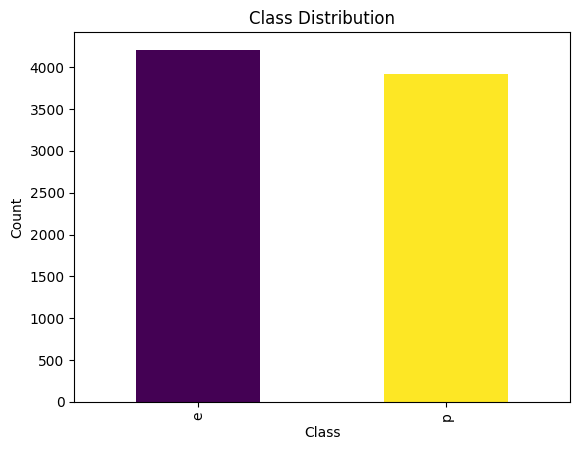

In [3]:
counts = df['class'].value_counts()
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(counts)))

counts.plot(kind='bar', color=colors)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [7]:
K_values = [3, 5, 7, 8, 9, 10, 11, 12, 15, 18, 22]

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

X = df.drop('class', axis=1)
y = df['class']

X_enc = X.apply(LabelEncoder().fit_transform)

mi = mutual_info_classif(X_enc, y)

feature_ranking = (
    pd.Series(mi, index=X.columns)
    .sort_values(ascending=False)
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

models = {
    "DT": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "LR": LogisticRegression(max_iter=1000)
}

from sklearn.model_selection import cross_val_score
import numpy as np

results = {}

for k in K_values:
    top_features = feature_ranking.index[:k]
    X_k = X_enc[top_features]

    scores = {}
    for name, model in models.items():
        cv_score = cross_val_score(
            model, X_k, y,
            cv=5,
            scoring='accuracy'
        ).mean()
        scores[name] = cv_score

    results[k] = scores


summary = pd.DataFrame(results).T
summary['min_score'] = summary.min(axis=1)
summary['mean_score'] = summary.mean(axis=1)

print(summary)

best_k = summary['min_score'].idxmax()
print("Optimal K:", best_k)

selected_features = feature_ranking.index[:best_k]

for i, feat in enumerate(selected_features, start=1):
    print(f"{i}. {feat}")


          DT        RF       KNN       SVM        LR  min_score  mean_score
3   0.912461  0.900638  0.889932  0.849426  0.728226   0.728226    0.834818
5   0.913321  0.902485  0.890055  0.822965  0.750991   0.750991    0.838468
7   0.919232  0.896574  0.875401  0.836257  0.712453   0.712453    0.825395
8   0.907409  0.908396  0.873185  0.843645  0.731532   0.731532    0.832617
9   0.918246  0.908886  0.880569  0.842165  0.840728   0.840728    0.871887
10  0.906423  0.911842  0.879953  0.836256  0.841713   0.836256    0.868741
11  0.912335  0.909872  0.881307  0.844751  0.841836   0.841836    0.871989
12  0.911596  0.904946  0.880691  0.833054  0.856726   0.833054    0.870011
15  0.902975  0.907162  0.889679  0.838340  0.817803   0.817803    0.862294
18  0.925138  0.899650  0.883156  0.851018  0.821374   0.821374    0.866952
22  0.920212  0.901251  0.880816  0.841292  0.830234   0.830234    0.867340
Optimal K: 11
1. odor
2. spore-print-color
3. gill-color
4. ring-type
5. stalk-surface-a

In [9]:
selected_features = feature_ranking.index[:3]
X_best = X_enc[selected_features]

In [4]:
from sklearn.model_selection import GridSearchCV

param_grids = {
    "DT": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 3, 5, 8, 10, 15],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 5, 10]
    },

    "RF": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5],
        "max_features": ["sqrt", "log2"]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9, 11, 15],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    },
     "SVM": {
        "C": [0.01, 0.1, 1, 10, 100],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto", 0.01, 0.1, 1]
    },

    "LR": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs", "liblinear"]
    }
}

In [10]:
best_models = {}
best_scores = {}

for i in range(3, 6):
    selected_features = feature_ranking.index[:i]
    X_best = X_enc[selected_features]

    best_models[i] = {}
    best_scores[i] = {}

    for name, model in models.items():
        print(f"\nTuning {name} with top {i} features...")

        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            cv=5,
            scoring="accuracy",
            n_jobs=-1
        )

        grid.fit(X_best, y)

        best_models[i][name] = grid.best_estimator_
        best_scores[i][name] = grid.best_score_

        print("Best CV accuracy:", grid.best_score_)
        print("Best params:", grid.best_params_)



Tuning DT with top 3 features...
Best CV accuracy: 0.9124608563849943
Best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Tuning RF with top 3 features...
Best CV accuracy: 0.9026086396362258
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Tuning KNN with top 3 features...
Best CV accuracy: 0.9261308829101932
Best params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

Tuning SVM with top 3 features...
Best CV accuracy: 0.9252705570291777
Best params: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Tuning LR with top 3 features...
Best CV accuracy: 0.7546803334596437
Best params: {'C': 0.01, 'solver': 'liblinear'}

Tuning DT with top 4 features...
Best CV accuracy: 0.9124608563849943
Best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Tuning RF with top 4 features...
Best CV accuracy: 0.8917730200833649

In [11]:
best_k = 5
best_model_name = "SVM"

best_svm = best_models[best_k][best_model_name]


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def select_features(X):
    return X[selected_features]

feature_selector = FunctionTransformer(select_features, validate=False)

final_pipeline = Pipeline([
    ("feature_selection", feature_selector),
    ("classifier", best_svm)
])

In [12]:
import joblib
import os

os.makedirs("pipelines", exist_ok=True)

model_path = "pipelines/svm_top5_pipeline.joblib"
joblib.dump(final_pipeline, model_path)

print(f"Saved model to {model_path}")

Saved model to pipelines/svm_top5_pipeline.joblib


In [13]:
import joblib

# Save the model itself (no feature selector)
model_filename = "best_svm_model.pkl"
joblib.dump(best_svm, model_filename)

print(f"Saved model to {model_filename}")


Saved model to best_svm_model.pkl


In [21]:
for col in X.columns:
    mapping = dict(zip(X[col], X_enc[col]))
    print(f"{col}: {mapping}")

print(X_best)


cap-shape: {'x': 5, 'b': 0, 's': 4, 'f': 2, 'k': 3, 'c': 1}
cap-surface: {'s': 2, 'y': 3, 'f': 0, 'g': 1}
cap-color: {'n': 4, 'y': 9, 'w': 8, 'g': 3, 'e': 2, 'p': 5, 'b': 0, 'u': 7, 'c': 1, 'r': 6}
bruises: {'t': 1, 'f': 0}
odor: {'p': 6, 'a': 0, 'l': 3, 'n': 5, 'f': 2, 'c': 1, 'y': 8, 's': 7, 'm': 4}
gill-attachment: {'f': 1, 'a': 0}
gill-spacing: {'c': 0, 'w': 1}
gill-size: {'n': 1, 'b': 0}
gill-color: {'k': 4, 'n': 5, 'g': 2, 'p': 7, 'w': 10, 'h': 3, 'u': 9, 'e': 1, 'b': 0, 'r': 8, 'y': 11, 'o': 6}
stalk-shape: {'e': 0, 't': 1}
stalk-root: {'e': 3, 'c': 2, 'b': 1, 'r': 4, '?': 0}
stalk-surface-above-ring: {'s': 2, 'f': 0, 'k': 1, 'y': 3}
stalk-surface-below-ring: {'s': 2, 'f': 0, 'y': 3, 'k': 1}
stalk-color-above-ring: {'w': 7, 'g': 3, 'p': 6, 'n': 4, 'b': 0, 'e': 2, 'o': 5, 'c': 1, 'y': 8}
stalk-color-below-ring: {'w': 7, 'p': 6, 'g': 3, 'b': 0, 'n': 4, 'e': 2, 'y': 8, 'o': 5, 'c': 1}
veil-type: {'p': 0}
veil-color: {'w': 2, 'n': 0, 'o': 1, 'y': 3}
ring-number: {'o': 1, 't': 2, 'n'

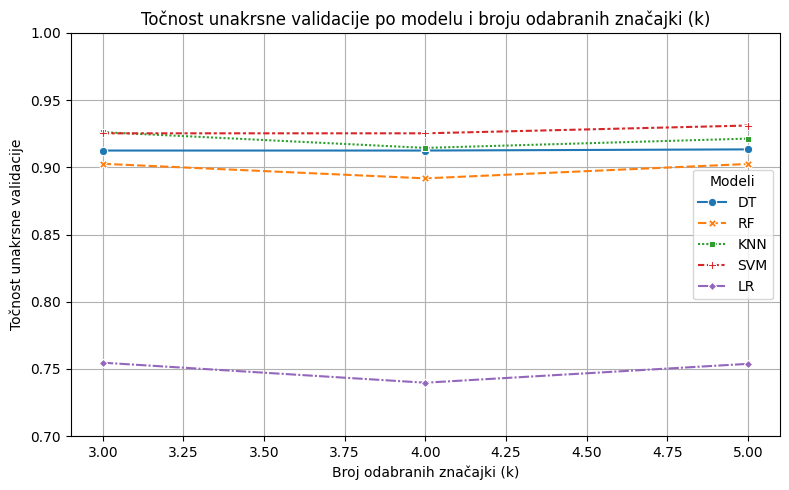

/var/folders/lf/c3gcydw17wqgxf7109kml5740000gn/T/ipykernel_9594/48669694.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_ranking.values, y=feature_ranking.index, palette="viridis")


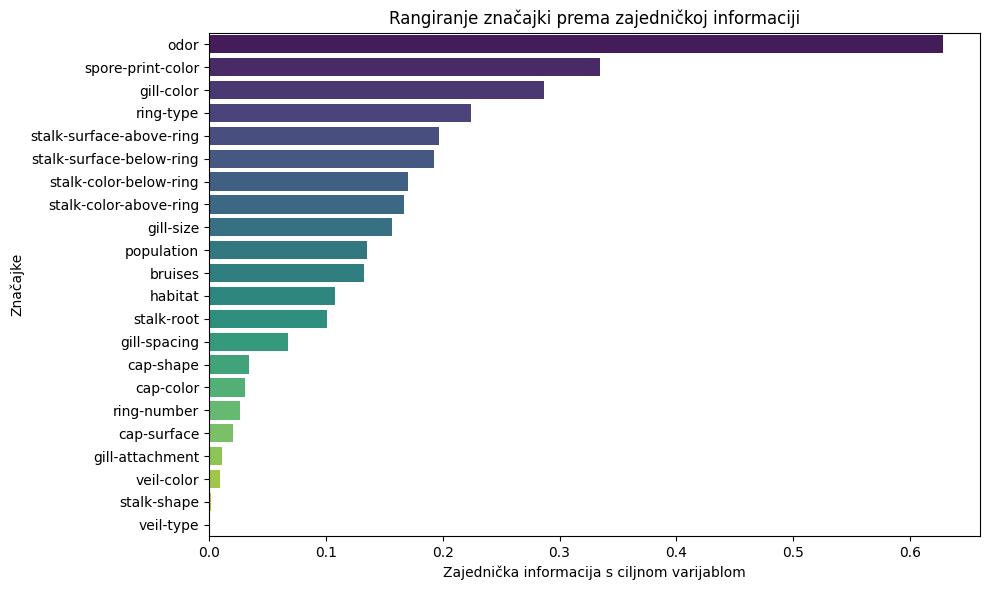

In [ ]:
import seaborn as sns


os.makedirs("images", exist_ok=True)


cv_df = pd.DataFrame(best_scores).T
cv_df.index.name = 'Broj odabranih značajki (k)'

plt.figure(figsize=(8,5))
sns.lineplot(data=cv_df, markers=True)
plt.title("Točnost unakrsne validacije po modelu i broju odabranih značajki (k)")
plt.xlabel("Broj odabranih značajki (k)")
plt.ylabel("Točnost unakrsne validacije")
plt.ylim(0.7, 1.0) 
plt.grid(True)
plt.legend(title="Modeli")
plt.tight_layout()
plt.savefig("images/cv_scores.png", dpi=300)
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=feature_ranking.values, y=feature_ranking.index, palette="viridis")
plt.title("Rangiranje značajki prema zajedničkoj informaciji")
plt.xlabel("Zajednička informacija s ciljnom varijablom")
plt.ylabel("Značajke")
plt.tight_layout()
plt.savefig("images/feature_importance.png", dpi=300)
plt.show()
